<a href="https://colab.research.google.com/github/avisekksarma/Fraud-detection/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data files :

train_identity.csv <br>
train_transaction.csv <br>
test_identity.csv <br>
test_transaction.csv <br>


Transaction Table

TransactionDT: timedelta from a given reference datetime (not an actual timestamp) <br>
TransactionAMT: transaction payment amount in USD <br>
ProductCD: product code, the product for each transaction <br>
card1 - card6: payment card information, such as card type, card category, issue bank, country, etc. <br>
addr: address <br>
dist: distance <br>
P_ and (R__) emaildomain: purchaser and recipient email domain <br>
C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.<br>
D1-D15: timedelta, such as days between previous transaction, etc.<br>
M1-M9: match, such as names on card and address, etc.<br>
Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.<br>

**Categorical Features:** <br>
ProductCD
card1 - card6 <br>
addr1, addr2<br>
Pemaildomain Remaildomain <br>
M1 - M9

**Identity Table** <br>
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

**Categorical Features:** <br>
DeviceType <br>
DeviceInfo <br>
id12 - id38 <br>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive' , force_remount=True)

Mounted at /content/gdrive


In [ ]:
# import zipfile
# zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Fraud_detection/ieee-fraud-detection.zip", 'r')
# zip_ref.extractall("/content/gdrive/My Drive/Fraud_detection/")
# zip_ref.close()

In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline

# disable the warning about settingwithcopy warning:
pd.set_option('chained_assignment',None)

In [ ]:
os.chdir('//content/gdrive/My Drive/Fraud_detection/')
!ls

data_clean.ipynb  minification.ipynb	 sub_lgb.csv	       train_identity.csv
eda.ipynb	  model.ipynb		 test_identity.csv     train_transaction.csv
fe.ipynb	  sample_submission.csv  test_transaction.csv


In [ ]:
train_identity = pd.read_csv("train_identity.csv")
train_transaction = pd.read_csv("train_transaction.csv")

test_identity = pd.read_csv("test_identity.csv")
test_transaction = pd.read_csv("test_transaction.csv")

In [ ]:
train_identity.head(100)

NameError: ignored

In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print('Number of row in transaction:', len(train_transaction))
print('Number of row in identity:', len(train_identity))

Number of row in transaction: 590540
Number of row in identity: 144233


In [ ]:
train_full = pd.merge(train_identity, train_transaction, on = 'TransactionID')

Train and test data are splitted by time

Text(0.5, 1.0, 'Distribution of TransactionDT')

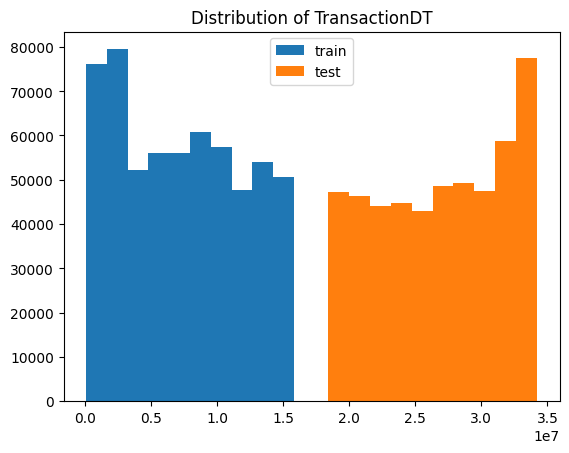

In [ ]:
plt.hist(train_transaction['TransactionDT'], label='train')
plt.hist(test_transaction['TransactionDT'], label='test')
plt.legend()
plt.title('Distribution of TransactionDT')

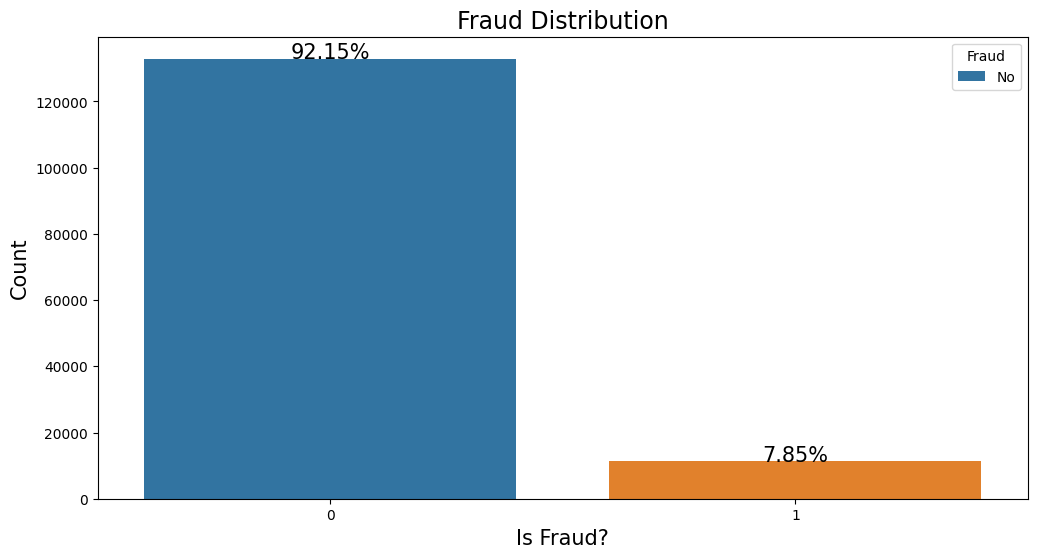

In [ ]:
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'isFraud', data = train_full)
g.set_title("Fraud Distribution", fontsize = 17)
g.set_xlabel("Is Fraud?", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
plt.legend(title='Fraud', labels=['No', 'Yes'])

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train_full) * 100),
            ha="center", fontsize=15)

In [ ]:
train_full_cat = train_full.filter(regex='id|card|ProductCD|addr|email|M|DeviceType|DeviceInfo')

In [ ]:
train_full_cat.shape

(144233, 60)

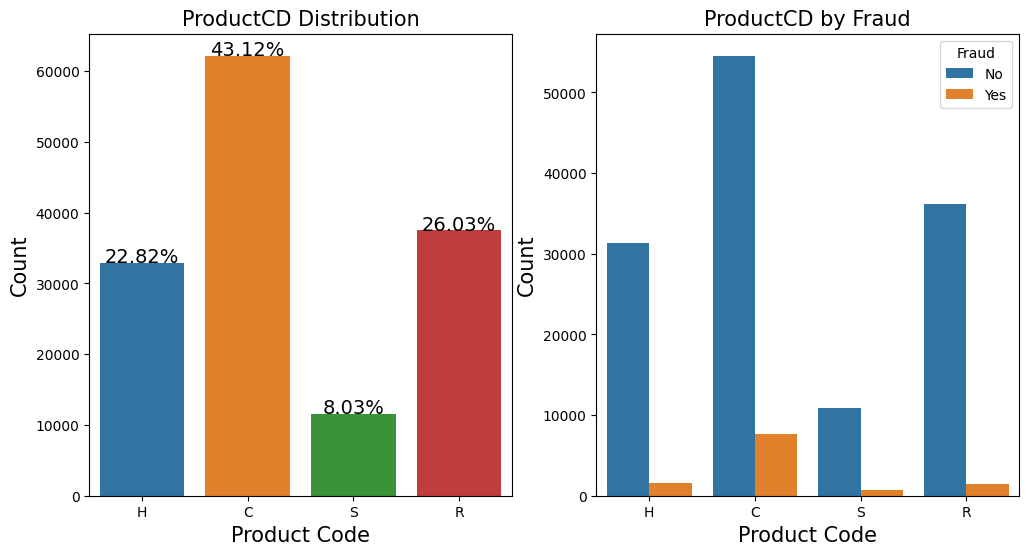

In [ ]:
plt.figure(figsize=(12,6))

total = len(train_full_cat)

plt.subplot(121)
g = sns.countplot(x = 'ProductCD', data = train_full_cat)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)

plt.subplot(122)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_full)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [ ]:
# grouped table
train_full.groupby('ProductCD')['isFraud'].value_counts(normalize = True)

ProductCD  isFraud
C          0          0.877155
           1          0.122845
H          0          0.952261
           1          0.047739
R          0          0.962102
           1          0.037898
S          0          0.940958
           1          0.059042
Name: isFraud, dtype: float64

<Axes: xlabel='ProductCD', ylabel='TransactionAmt'>

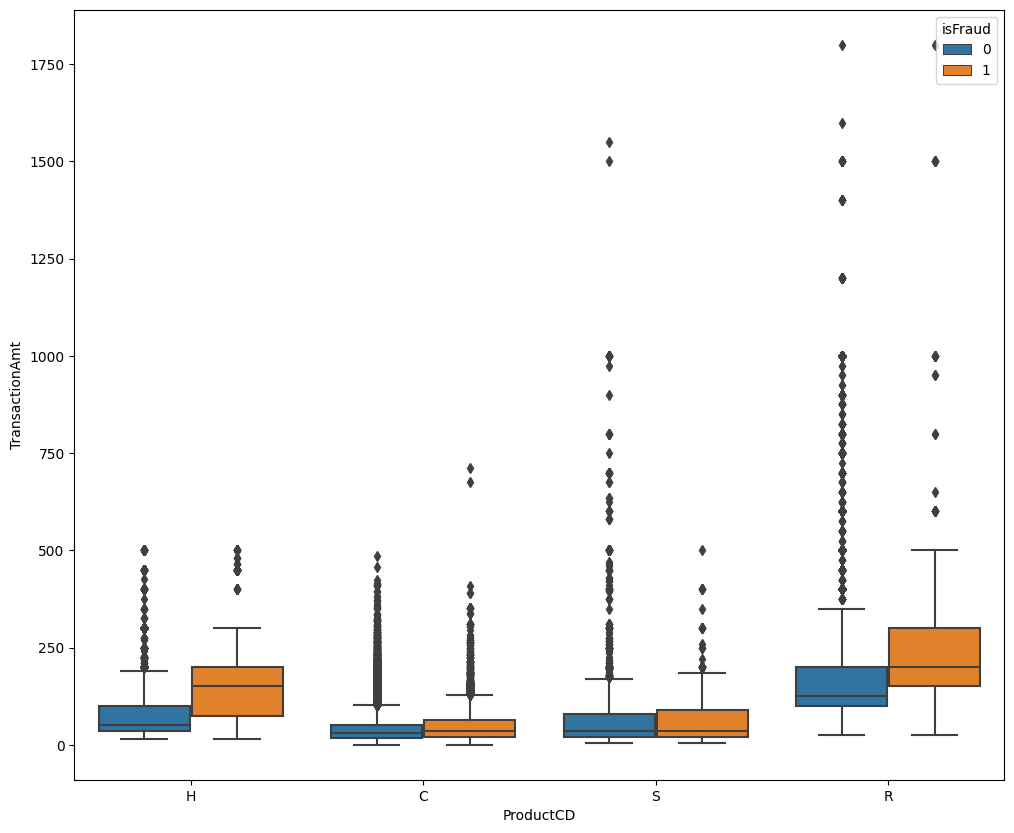

In [ ]:
plt.figure(figsize=(12,10))
sns.boxplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud', data = train_full)

In [ ]:
train_full_cat.describe().loc[:,'card1':'card5']

,card1,card2,card3,card5
count,144233.000000,143331.000000,144061.000000,143277.000000
mean,9879.012528,391.325526,161.695504,191.166293
std,5047.643179,160.327848,19.410116,44.774337
min,1000.000000,100.000000,100.000000,100.000000
25%,5713.000000,264.000000,150.000000,138.000000
50%,9633.000000,408.000000,150.000000,224.000000
75%,15063.000000,545.000000,185.000000,226.000000
max,18396.000000,600.000000,231.000000,237.000000


In [ ]:
train_full_cat.loc[:,'card1':'card5'].nunique()

card1    8499
card2     482
card3     103
card4       4
card5     106
dtype: int64

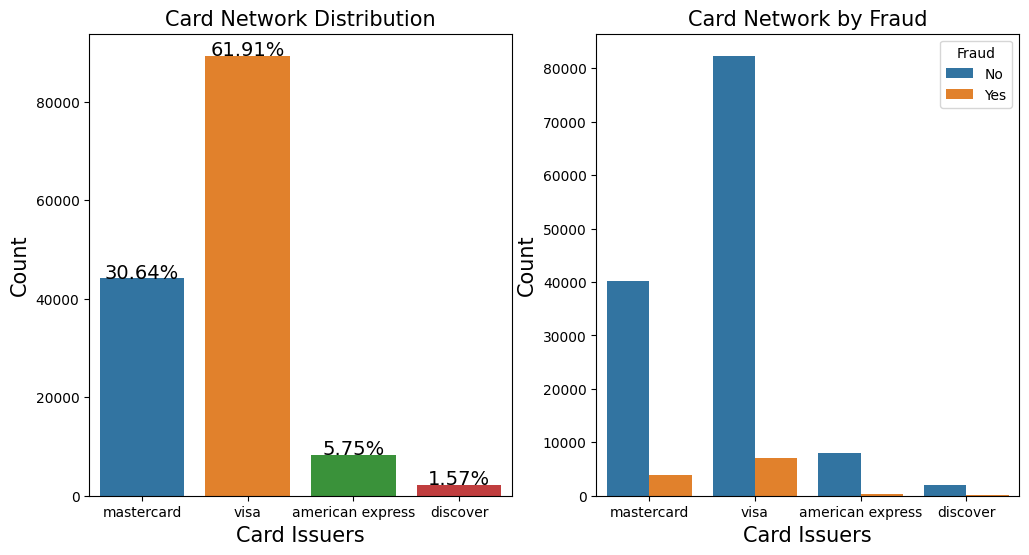

In [ ]:
plt.figure(figsize=(12,6))

total = len(train_full_cat)

plt.subplot(121)
g = sns.countplot(x = 'card4', data = train_full_cat)
g.set_title('Card Network Distribution', fontsize = 15)
g.set_xlabel("Card Issuers", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)

plt.subplot(122)
g1 = sns.countplot(x='card4', hue='isFraud', data=train_full)
g1.set_title('Card Network by Fraud', fontsize = 15)
g1.set_xlabel("Card Issuers", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [ ]:
# grouped table
train_full.groupby('card4')['isFraud'].value_counts(normalize = True)

card4             isFraud
american express  0          0.971198
                  1          0.028802
discover          0          0.921889
                  1          0.078111
mastercard        0          0.911284
                  1          0.088716
visa              0          0.921970
                  1          0.078030
Name: isFraud, dtype: float64

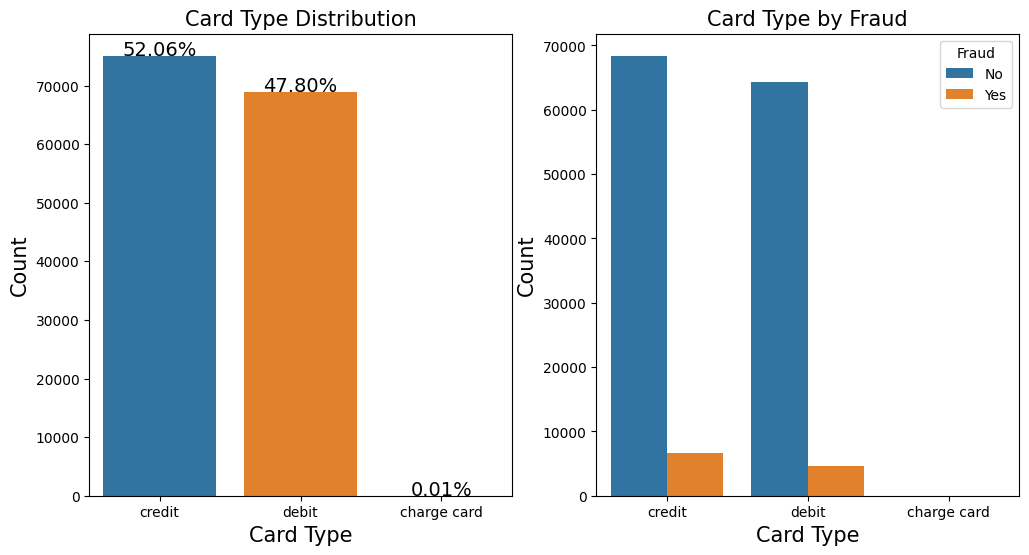

In [ ]:
plt.figure(figsize=(12,6))

total = len(train_full_cat)

plt.subplot(121)
g = sns.countplot(x = 'card6', data = train_full)
g.set_title('Card Type Distribution', fontsize = 15)
g.set_xlabel("Card Type", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14)

plt.subplot(122)
g1 = sns.countplot(x='card6', hue='isFraud', data=train_full)
g1.set_title('Card Type by Fraud', fontsize = 15)
g1.set_xlabel("Card Type", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [ ]:
# grouped table
train_full.groupby('card6')['isFraud'].value_counts(normalize = True)

card6        isFraud
charge card  0          1.000000
credit       0          0.910867
             1          0.089133
debit        0          0.933096
             1          0.066904
Name: isFraud, dtype: float64

  **Email Distribution**

1. Purchaser Email

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),
 [Text(0, 0, 'gmail.com'),
  Text(1, 0, 'anonymous.com'),
  Text(2, 0, 'hotmail.com'),
  Text(3, 0, 'aol.com'),
  Text(4, 0, 'yahoo.com'),
  Text(5, 0, 'outlook.com'),
  Text(6, 0, 'charter.net'),
  Text(7, 0, 'comcast.net'),
  Text(8, 0, 'optonline.net'),
  Text(9, 0, 'embarqmail.com'),
  Text(10, 0, 'live.com.mx'),
  Text(11, 0, 'icloud.com'),
  Text(12, 0, 'juno.com'),
  Text(13, 0, 'att.net'),
  Text(14, 0, 'msn.com'),
  Text(15, 0, 'yahoo.com.mx'),
  Text(16, 0, 'cox.net'),
  Text(17, 0, 'servicios-ta.com'),
  Text(18, 0, 'me.com'),
  Text(19, 0, 'hotmail.es'),
  Text(20, 0, 'live.com'),
  Text(21, 0, 'verizon.net'),
  Text(22, 0, 'bellsouth.net'),
  Text(23, 0, 'sbcglobal.net'),
  Text(24, 0, 'gmx.de'),
  Text(25, 

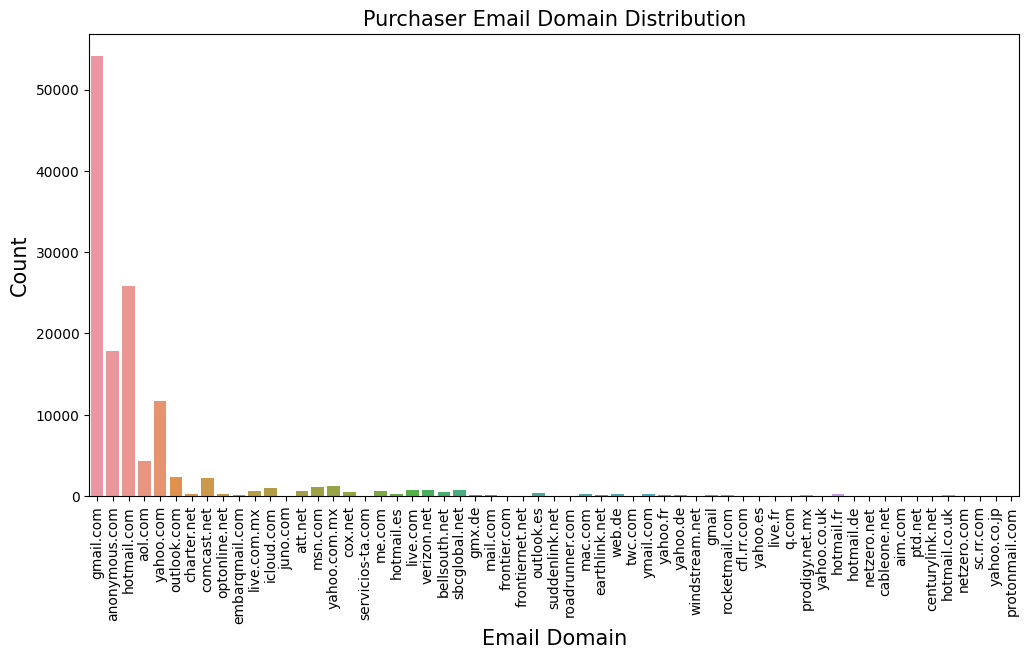

In [ ]:
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = train_full)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation='vertical')

In [ ]:
train_full["P_parent_emaildomain"] = train_full["P_emaildomain"].str.split('.', expand = True)[[0]]

Text(0, 0.5, 'Fraud Rate')

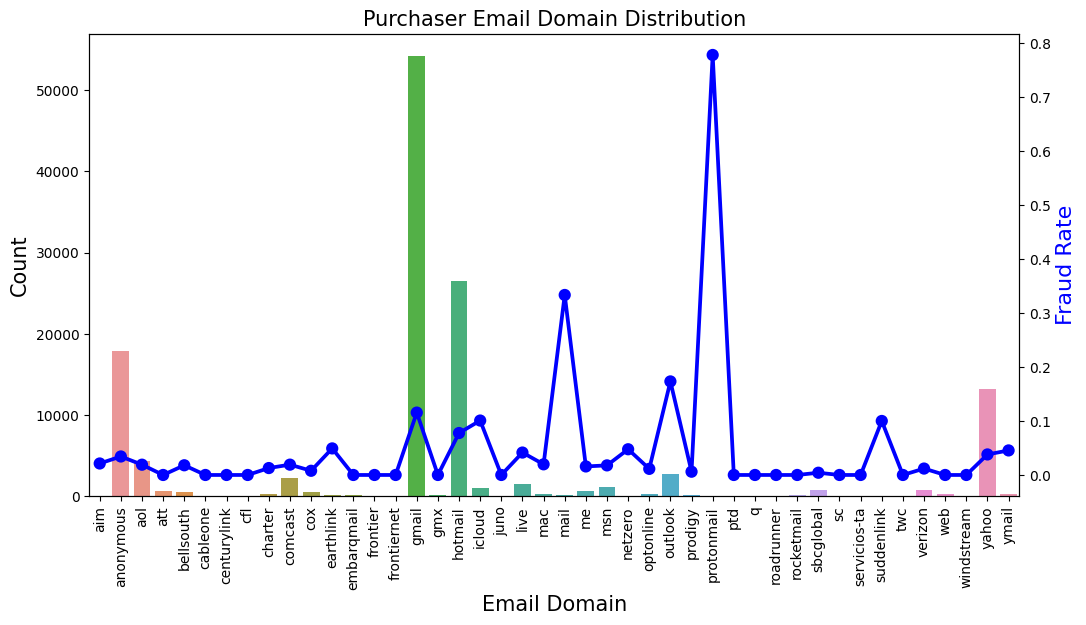

In [ ]:
P_emaildomain_fraud_rate = train_full.groupby('P_parent_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_parent_emaildomain', data = train_full, order = P_emaildomain_fraud_rate.index)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = P_emaildomain_fraud_rate.index, y = P_emaildomain_fraud_rate, color = 'blue')
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

2. Receipent Email

Text(0, 0.5, 'Fraud Rate')

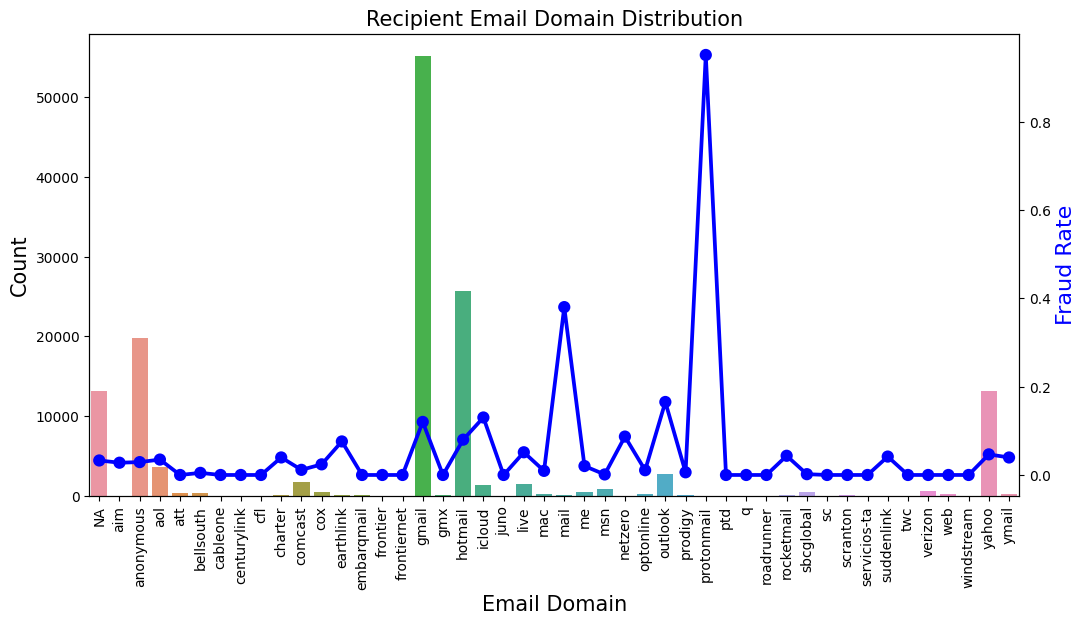

In [ ]:
train_full["R_parent_emaildomain"] = train_full["R_emaildomain"].str.split('.', expand = True)[[0]]
train_full["R_parent_emaildomain"].fillna("NA", inplace=True)

R_emaildomain_fraud_rate = train_full.groupby('R_parent_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'R_parent_emaildomain', data = train_full, order = R_emaildomain_fraud_rate.index)
g.set_title('Recipient Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = R_emaildomain_fraud_rate.index, y = R_emaildomain_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

In [ ]:
def visualize_cat_cariable(variable, df=train_full):
    train_full[variable].fillna("NA", inplace=True)
    variable_fraud_rate = df.groupby(variable)['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

    plt.figure(figsize=(12,6))

    g = sns.countplot(x = variable, data = df, order = variable_fraud_rate.index)
    g.set_title('{} Count'.format(variable), fontsize = 15)
    g.set_xlabel("{}".format(variable), fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.xticks(rotation= "vertical")

    r = g.twinx()
    r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
    r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

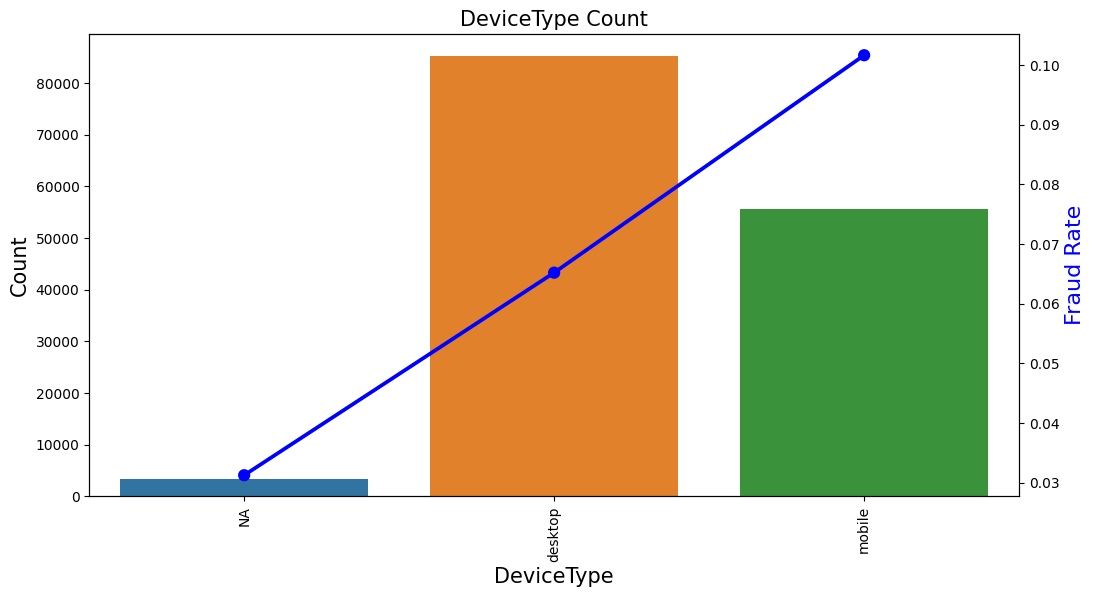

In [ ]:
visualize_cat_cariable('DeviceType')

In [ ]:
devicelist = train_full.groupby('DeviceInfo').filter(lambda x: len(x) >500)['DeviceInfo'].unique()

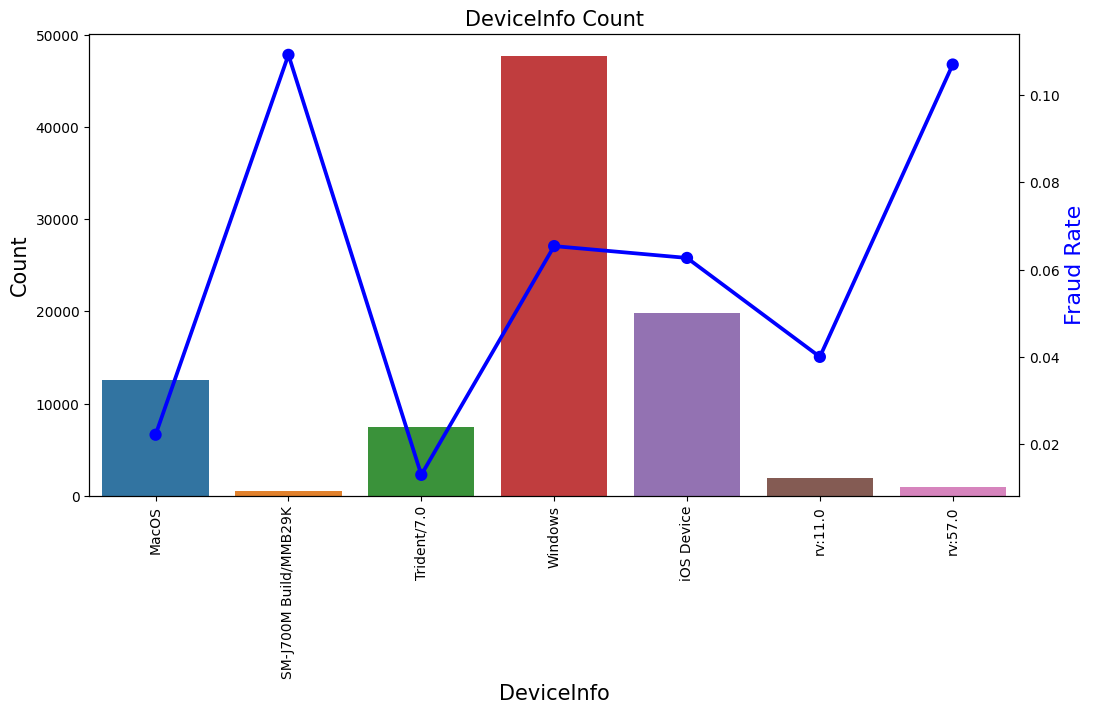

In [ ]:
visualize_cat_cariable('DeviceInfo', df = train_full[train_full['DeviceInfo'].isin(devicelist)])

Operating Systems

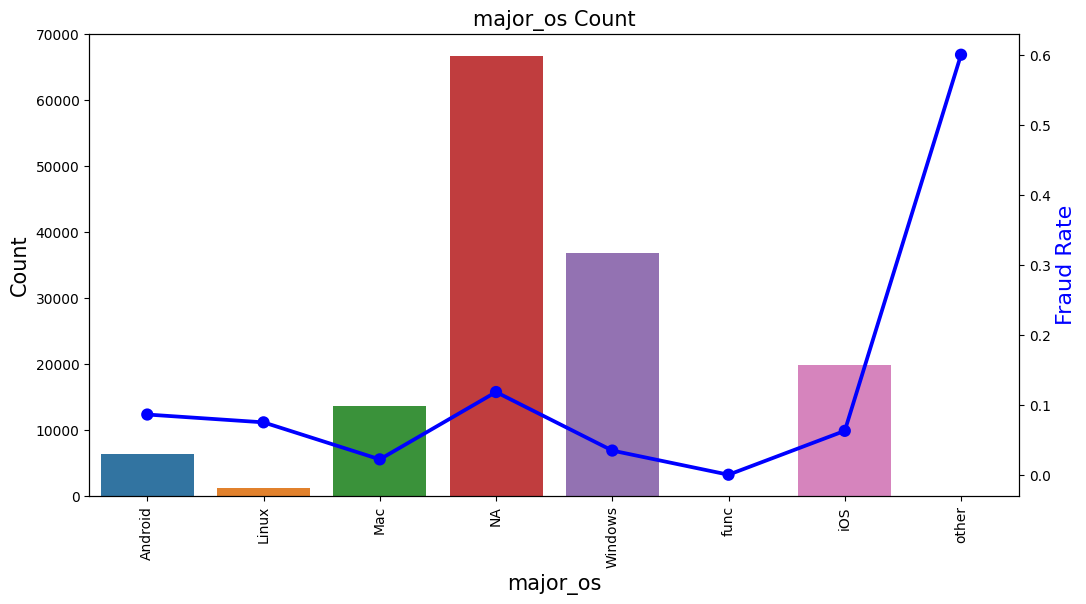

In [ ]:
train_full['major_os'] = train_full["id_30"].str.split(' ', expand = True)[[0]]

visualize_cat_cariable('major_os')

Browsers

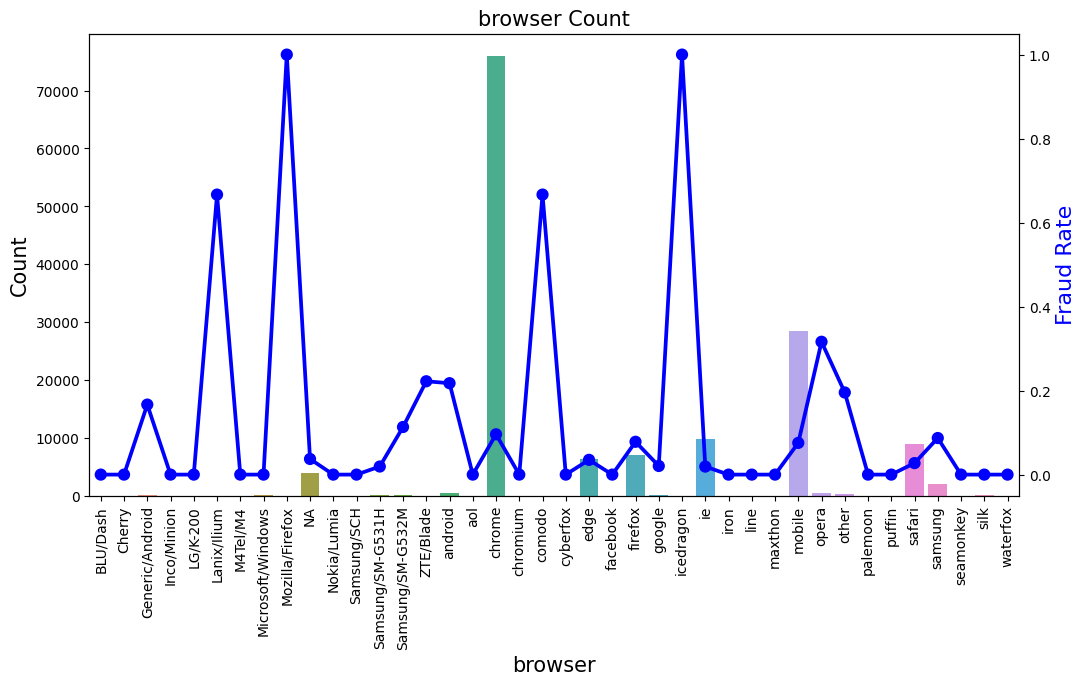

In [ ]:
train_full['browser'] = train_full["id_31"].str.split(' ', expand = True)[[0]]

visualize_cat_cariable('browser')

Numerical Varriable

<ipython-input-38-4aab7271064a>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_full['TransactionAmt'], kde= False)
<ipython-input-38-4aab7271064a>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log10(train_full['TransactionAmt']), kde= False)
<ipython-input-38-4aab7271064a>:13: User

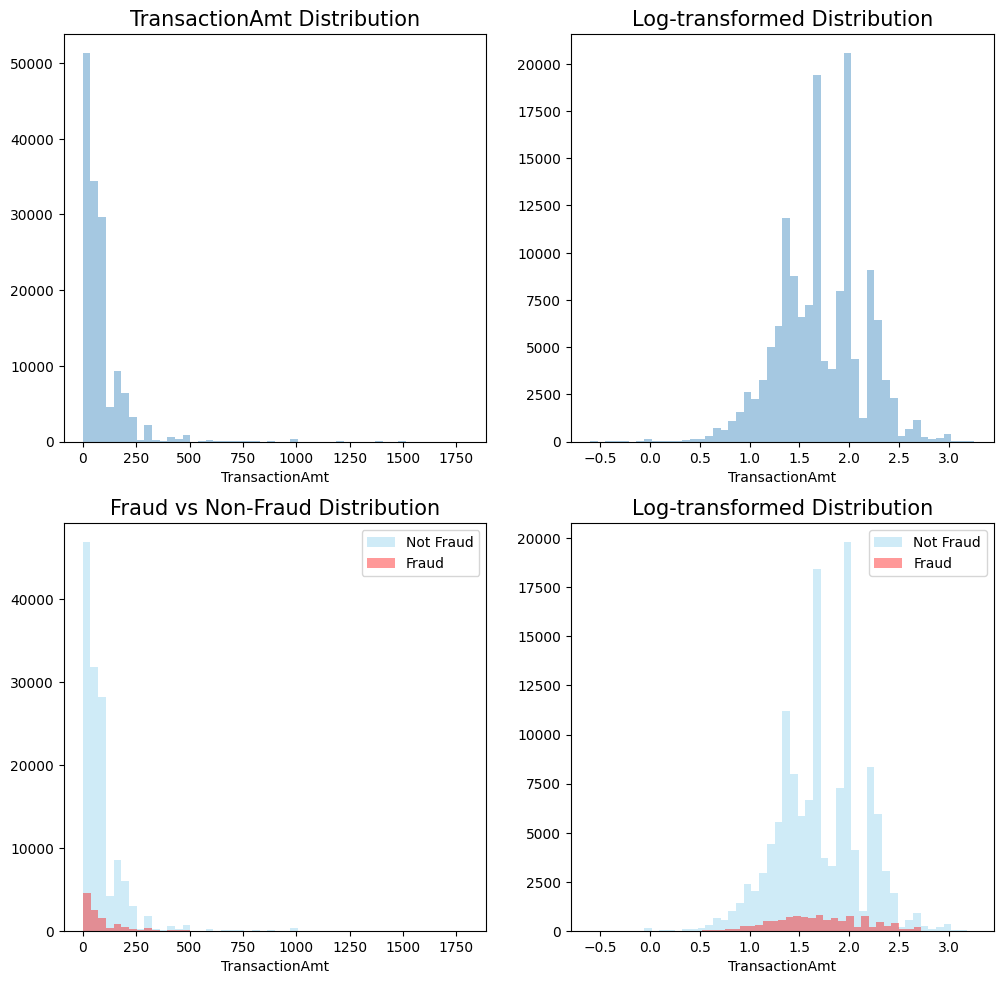

In [ ]:

plt.figure(figsize=(12,18))


plt.subplot(321)
sns.distplot(train_full['TransactionAmt'], kde= False)
plt.title('{} Distribution'.format('TransactionAmt'), fontsize = 15)

plt.subplot(322)
sns.distplot(np.log10(train_full['TransactionAmt']), kde= False)
plt.title('Log-transformed Distribution', fontsize = 15)

plt.subplot(323)
sns.distplot(train_full[train_full['isFraud'] == 0]['TransactionAmt'], color = 'skyblue', kde= False, label = 'Not Fraud')
sns.distplot(train_full[train_full['isFraud'] == 1]['TransactionAmt'], color = 'red', kde= False , label = 'Fraud')
plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
plt.legend()

plt.subplot(324)
sns.distplot(np.log10(train_full[train_full['isFraud'] == 0]['TransactionAmt']), color = 'skyblue', kde= False, label = 'Not Fraud')
sns.distplot(np.log10(train_full[train_full['isFraud'] == 1]['TransactionAmt']), color = 'red', kde= False , label = 'Fraud')
plt.title('Log-transformed Distribution', fontsize = 15)
plt.legend()

NaNs

In [ ]:
# Tackling Class Imbalance
# https://www.kaggle.com/shahules/tackling-class-imbalance

In [ ]:
# Dimensionality Reduction and Clustering

# TODO : do dimensionality reduction , lowwer memory usage

# # PCA Implementation


# import time
# from sklearn.decomposition import PCA
# t0 = time.time()
# X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(train_transaction)
# t1 = time.time()
# print("PCA took {:.2} s".format(t1 - t0))

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# f, (ax1) = plt.subplots(1, 1, figsize=(12,6))
# # labels = ['No Fraud', 'Fraud']
# f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

# blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
# red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# # PCA scatter plot
# ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
# ax1.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
# ax1.set_title('PCA', fontsize=14)

# ax1.grid(True)

# ax1.legend(handles=[blue_patch, red_patch])

In [ ]:
#Recursive Feature Elimination
# https://www.kaggle.com/nroman/recursive-feature-elimination

In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
len(train_transaction)

590540

In [ ]:
columns_to_encode = []
for f in train_transaction.columns:
  if train_transaction[f].dtype == 'object':
    columns_to_encode.append(f)


for col in columns_to_encode:
  fq_encode = train_transaction[col].value_counts(dropna=False) / len(train_transaction)
  train_transaction[col] = train_transaction[col].map(fq_encode)

In [ ]:
print(columns_to_encode)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,0.744522,13926,NaN,150.0,0.011263,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,0.744522,2755,404.0,150.0,0.320414,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,0.744522,4663,490.0,150.0,0.651551,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,0.744522,18132,567.0,150.0,0.320414,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,0.055922,4497,514.0,150.0,0.320414,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# def normalize_df(df):
#   normalized_df=(df-df.min())/(df.max()-df.min())
#   return normalized_df

# train_transaction=normalize_df(train_transaction)


In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,0.744522,13926,NaN,150.0,0.011263,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,0.744522,2755,404.0,150.0,0.320414,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,0.744522,4663,490.0,150.0,0.651551,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,0.744522,18132,567.0,150.0,0.320414,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,0.055922,4497,514.0,150.0,0.320414,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Drop related V Columns
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id

#Tackling Class Imbalance
# https://www.kaggle.com/shahules/tackling-class-imbalance

#Recursive Feature Elimination
# https://www.kaggle.com/nroman/recursive-feature-elimination

In [ ]:
train_transaction.shape

(590540, 394)

In [ ]:
import gc
nans_df = train_transaction.isna()
nans_groups={}
i_cols = ['V'+str(i) for i in range(1,340)]
for col in train_transaction.columns:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

for k,v in nans_groups.items():
    print('####### NAN count =',k)
    print(v)

####### NAN count = 0
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
####### NAN count = 8933
['card2']
####### NAN count = 1565
['card3']
####### NAN count = 4259
['card5']
####### NAN count = 65706
['addr1', 'addr2']
####### NAN count = 352271
['dist1']
####### NAN count = 552913
['dist2']
####### NAN count = 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
####### NAN count = 280797
['D2']
####### NAN count = 262878
['D3']
####### NAN count = 168922
['D4']
####### NAN count = 309841
['D5']
####### NAN count = 517353
['D6']
####### NAN count = 551623
['D7']
####### NAN count = 515614
['D8', 'D9']
####### NAN count = 76022
['D10']
####### NAN count = 279287
['D11', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'

In [ ]:
Vs = nans_groups[279287]
Vtitle = 'V1 - V11, D11'

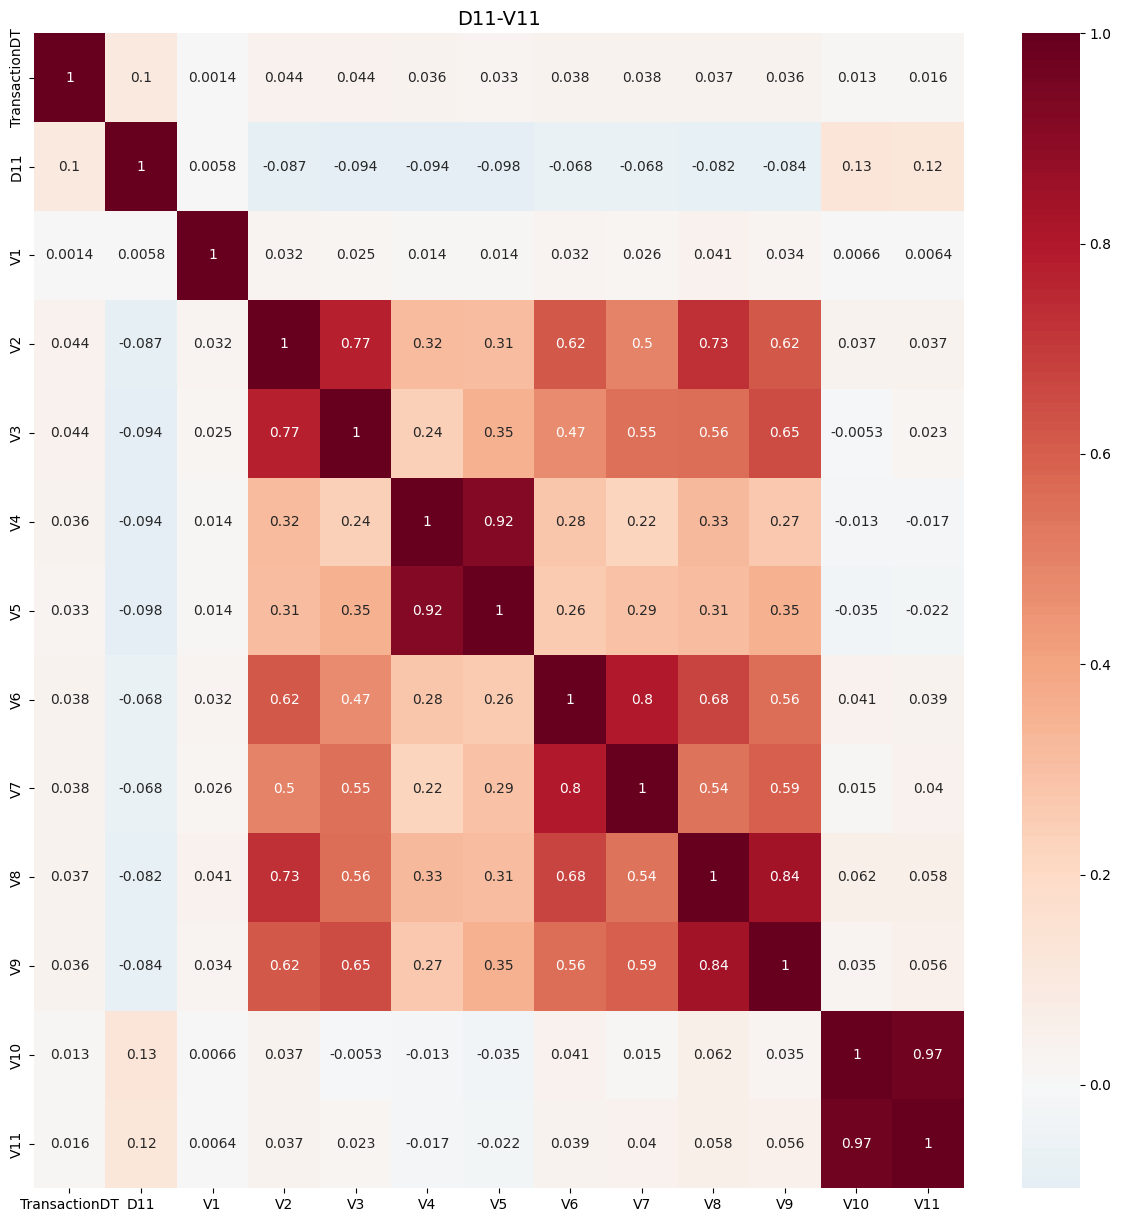

In [ ]:

def make_corr(Vs,Vtitle=''):
    cols = ['TransactionDT'] + Vs
    plt.figure(figsize=(15,15))
    sns.heatmap(train_transaction[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle!='': plt.title(Vtitle,fontsize=14)
    else: plt.title(Vs[0]+' - '+Vs[-1],fontsize=14)
    plt.show()
make_corr(Vs,Vtitle='D11-V11')

In [ ]:
grps = [[1],[2,3],[4,5],[6,7],[8,9],[10,11]]
def reduce_group(grps,c='V'):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = train_transaction[c+str(gg)].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
reduce_group(grps)

Use these [1, 3, 4, 6, 8, 11]


Similarily other obtained values of v are

In [ ]:
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]
v += [96, 98, 99, 104]
v += [107, 108, 111, 115, 117, 120, 121, 123]
v += [124, 127, 129, 130, 136]
v += [138, 139, 142, 147, 156, 162]
v += [165, 160, 166]
v += [178, 176, 173, 182]
v += [187, 203, 205, 207, 215]
v += [169, 171, 175, 180, 185, 188, 198, 210, 209]
v += [218, 223, 224, 226, 228, 229, 235]
v += [240, 258, 257, 253, 252, 260, 261]
v += [264, 266, 267, 274, 277]
v += [220, 221, 234, 238, 250, 271]
v += [294, 284, 285, 286, 291, 297]
v += [303, 305, 307, 309, 310, 320]
v += [281, 283, 289, 296, 301, 314]
v += [332, 325, 335, 338]

In [ ]:
print(v)

[1, 3, 4, 6, 8, 11, 13, 14, 17, 20, 23, 26, 27, 30, 36, 37, 40, 41, 44, 47, 48, 54, 56, 59, 62, 65, 67, 68, 70, 76, 78, 80, 82, 86, 88, 89, 91, 96, 98, 99, 104, 107, 108, 111, 115, 117, 120, 121, 123, 124, 127, 129, 130, 136, 138, 139, 142, 147, 156, 162, 165, 160, 166, 178, 176, 173, 182, 187, 203, 205, 207, 215, 169, 171, 175, 180, 185, 188, 198, 210, 209, 218, 223, 224, 226, 228, 229, 235, 240, 258, 257, 253, 252, 260, 261, 264, 266, 267, 274, 277, 220, 221, 234, 238, 250, 271, 294, 284, 285, 286, 291, 297, 303, 305, 307, 309, 310, 320, 281, 283, 289, 296, 301, 314, 332, 325, 335, 338]


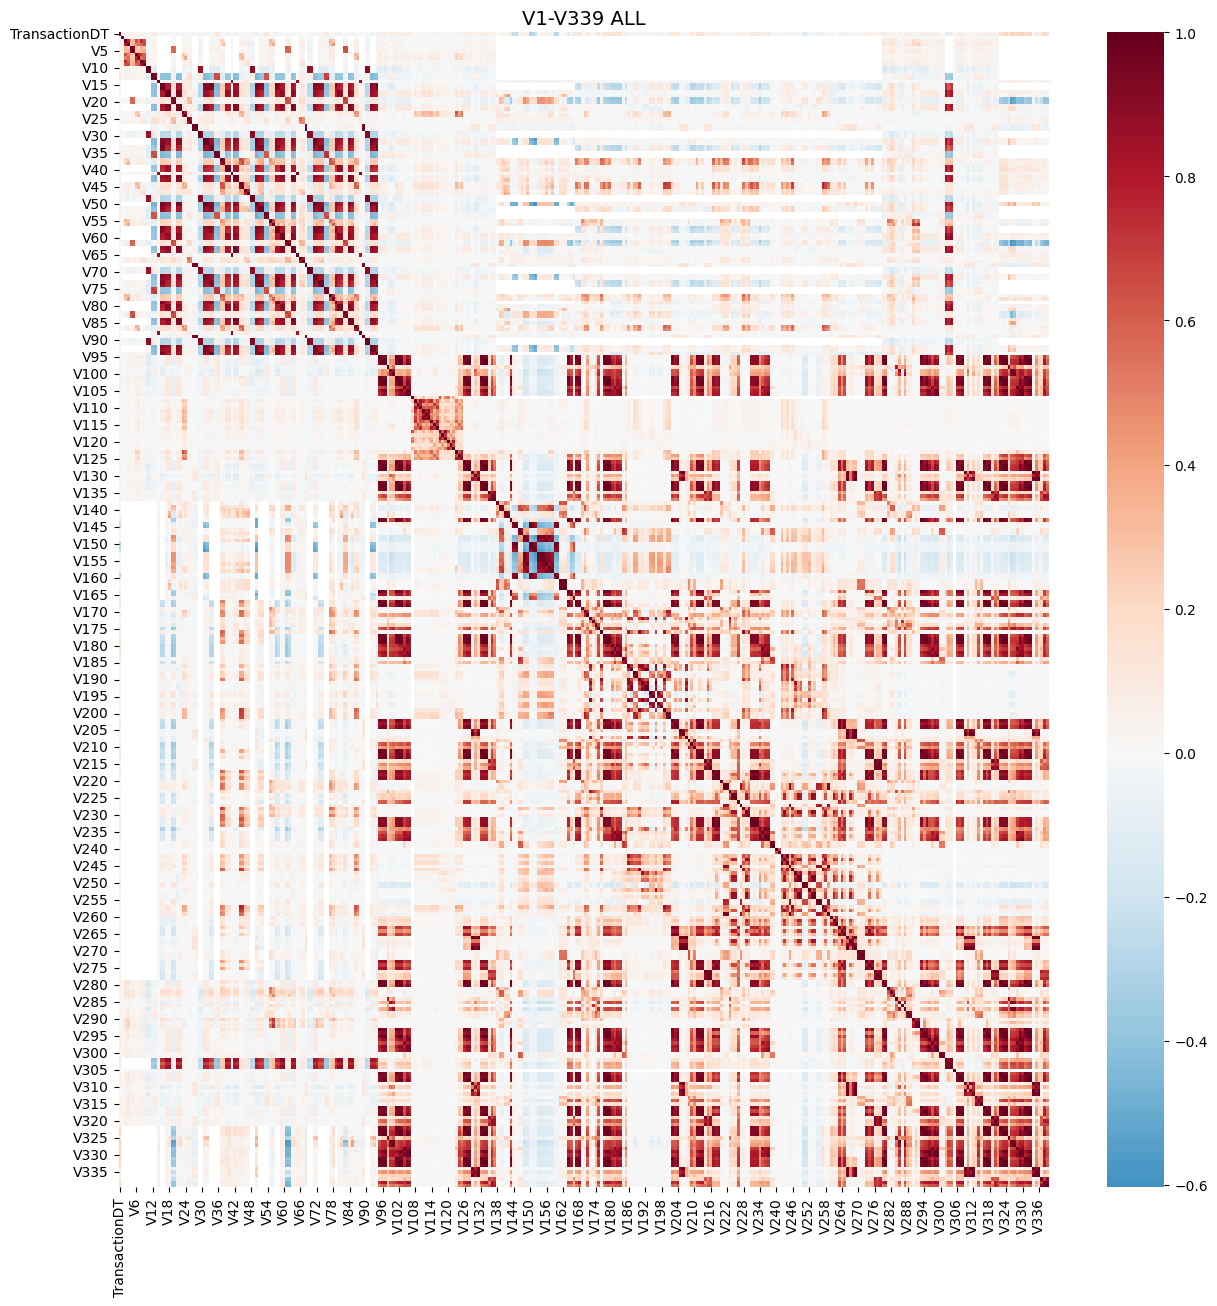

In [ ]:
cols = ['TransactionDT'] + ['V'+str(x) for x in range(1,340)]
train2 = train_transaction[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 ALL',fontsize=14)
plt.show()

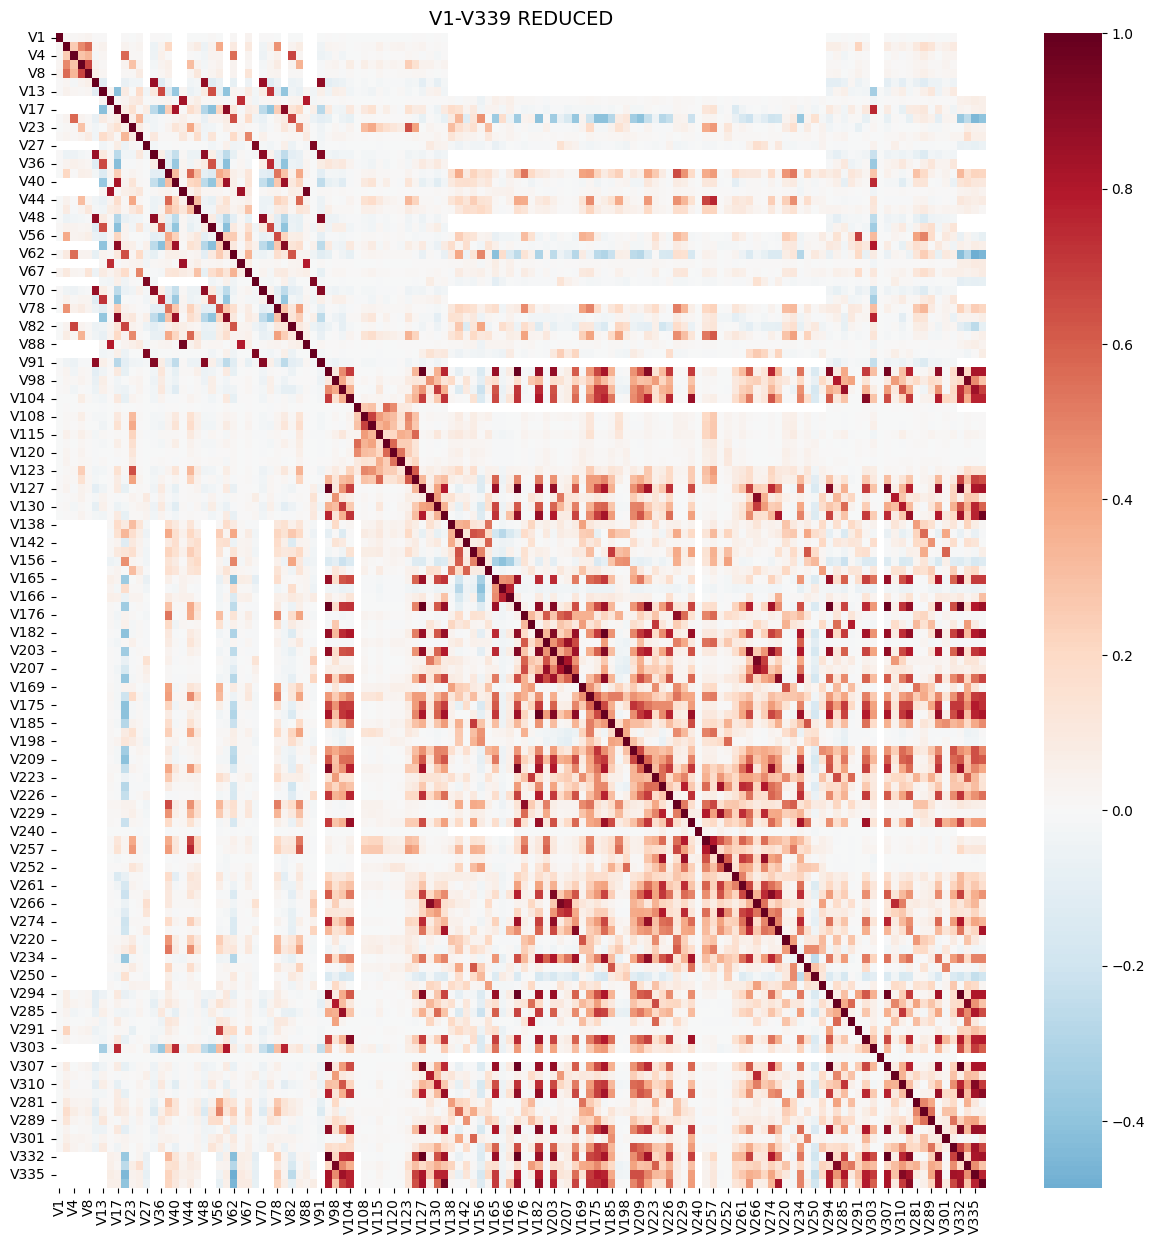

In [ ]:
cols =  ['V'+str(x) for x in v]
train2 = train_transaction[cols].sample(frac=0.2)
plt.figure(figsize=(15,15))
sns.heatmap(train2[cols].corr(), cmap='RdBu_r', annot=False, center=0.0)
plt.title('V1-V339 REDUCED',fontsize=14)
plt.show()

In [ ]:
len(v)

128

In [ ]:
total_v =[i for i in range(1,340)]
v_col_to_remove = [i for i in total_v if i not in v]
v_reduced = [ 'V'+str(i) for i in v_col_to_remove]
train_transaction.drop(v_reduced, axis=1, inplace=True)

In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V305,V307,V309,V310,V314,V320,V325,V332,V335,V338
0,2987000,0,86400,68.5,0.744522,13926,NaN,150.0,0.011263,142.0,...,1.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,0.744522,2755,404.0,150.0,0.320414,102.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,0.744522,4663,490.0,150.0,0.651551,166.0,...,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,0.744522,18132,567.0,150.0,0.320414,117.0,...,1.0,1758.0,0.0,354.0,0.0,0.0,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,0.055922,4497,514.0,150.0,0.320414,102.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_transaction.shape

(590540, 183)

In [ ]:
train_transaction.isnull().sum()

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
                   ...  
V320                  12
V325              508189
V332              508189
V335              508189
V338              508189
Length: 183, dtype: int64

In [ ]:
missing_values_count = (train_transaction.isnull().sum() / train_transaction.shape[0]) * 100
# print (missing_values_count[0:20])

columns_to_remove = []
for i in range(len(missing_values_count)):
  if missing_values_count[i] > 70 :
    columns_to_remove.append(train_transaction.columns.values[int(i)])


In [ ]:
train_transaction.head()
print(train_transaction.shape)

(590540, 183)


In [ ]:
columns_to_remove.append('TransactionID')
print(len(columns_to_remove))
print(columns_to_remove)
train_transaction.drop(columns_to_remove, axis=1, inplace=True)


65
['dist2', 'D6', 'D7', 'D8', 'D9', 'D12', 'D13', 'D14', 'V138', 'V139', 'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169', 'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185', 'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210', 'V215', 'V218', 'V220', 'V221', 'V223', 'V224', 'V226', 'V228', 'V229', 'V234', 'V235', 'V238', 'V240', 'V250', 'V252', 'V253', 'V257', 'V258', 'V260', 'V261', 'V264', 'V266', 'V267', 'V271', 'V274', 'V277', 'V325', 'V332', 'V335', 'V338', 'TransactionID']


In [ ]:
print(train_transaction.shape)
train_transaction.head()


(590540, 118)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V296,V297,V301,V303,V305,V307,V309,V310,V314,V320
0,0,86400,68.5,0.744522,13926,NaN,150.0,0.011263,142.0,0.252288,...,0.0,0.0,0.0,0.0,1.0,117.0,0.0,0.0,0.0,0.0
1,0,86401,29.0,0.744522,2755,404.0,150.0,0.320414,102.0,0.252288,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,86469,59.0,0.744522,4663,490.0,150.0,0.651551,166.0,0.744976,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,86499,50.0,0.744522,18132,567.0,150.0,0.320414,117.0,0.744976,...,0.0,0.0,0.0,0.0,1.0,1758.0,0.0,354.0,0.0,0.0
4,0,86506,50.0,0.055922,4497,514.0,150.0,0.320414,102.0,0.252288,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for col in train_transaction.columns:
  train_transaction[col].fillna(-999, inplace=True)

In [ ]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V296,V297,V301,V303,V305,V307,V309,V310,V314,V320
0,0,86400,68.5,0.744522,13926,-999.0,150.0,0.011263,142.0,0.252288,...,0.0,0.0,0.0,0.0,1.0,117.0,0.0,0.0,0.0,0.0
1,0,86401,29.0,0.744522,2755,404.0,150.0,0.320414,102.0,0.252288,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,86469,59.0,0.744522,4663,490.0,150.0,0.651551,166.0,0.744976,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,86499,50.0,0.744522,18132,567.0,150.0,0.320414,117.0,0.744976,...,0.0,0.0,0.0,0.0,1.0,1758.0,0.0,354.0,0.0,0.0
4,0,86506,50.0,0.055922,4497,514.0,150.0,0.320414,102.0,0.252288,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Recursive Feature Elimination
# https://www.kaggle.com/nroman/recursive-feature-elimination

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing
import gc

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
train_full.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V334,V335,V336,V337,V338,V339,P_parent_emaildomain,R_parent_emaildomain,major_os,browser
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,gmail,NA,Android,samsung
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,anonymous,NA,iOS,mobile
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,gmail,gmail,NA,chrome
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,hotmail,hotmail,NA,chrome
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,aol,NA,Mac,chrome


In [ ]:
d1 = pd.DataFrame({'one' : [1., 2., 3., 4.], 'two' : [4., 3., 2., 1.]})

d2 = pd.DataFrame({'one' : [5., 6., 7., 8.], 'two' : [9., 10., 11., 12.]})

d3 = pd.DataFrame({'one' : [15., 16., 17., 18.], 'two' : [19., 10., 11., 12.]})

In [ ]:
df = pd.concat([d1,d2,d3])
